In [1]:
import numpy as np
from torch import nn
import torch
import netCDF4 as nc
import pandas as pd
import pyproj
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [2]:
N = 1

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(N, 2*N, 3,padding=1),
            nn.Conv2d(2*N, 4*N, 3,padding=1),
            nn.Conv2d(4*N, 2*N, 3, padding=1), 
            nn.Conv2d(2*N, N, 3, padding=1)
        )

    def forward(self, x):
        print(x.shape)
        #x = torch.log(x)
        logits = self.linear_relu_stack(x)
        #logits = torch.exp(logits)
        return logits

In [3]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [4]:
ds = nc.Dataset('nor4km_data\\samples_2020.01.01_nonoverlap.nc')
latlons = (ds['gridLats'], ds['gridLons'])


In [5]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader) #dataloader is [[X_1, y_1],[X_2, y_2], ..., [X_n, y_n]]
    model.train() #puts model in training mode
    for batch, (X,y) in enumerate(dataloader): #X is input data, y is target data

        #compute prediction
        pred = model(X)
        loss = loss_fn(pred, y)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch *len(X)
            print(f'loss: {loss:>7f} [ {current:>5d}/{size:>5d}]')



In [13]:
def print_on_map(y, latlons, catch_data = None, depth =None):
    map = Basemap(projection='merc', llcrnrlon=-15.,llcrnrlat=55.,urcrnrlon=35.,urcrnrlat=80.,resolution='i' )
    fig = plt.figure()
    fig.set_size_inches(10,10)
    lats, lons = latlons
    pred_numpy= y.detach().numpy()[0,:,:]
    print(pred_numpy.shape)
    temperature = map.contourf(lons, lats,np.ma.masked_array(pred_numpy, mask=not depth.mask),100, latlon=True, cmap =plt.cm.RdYlBu_r)
    cb = map.colorbar(temperature,"bottom", size="5%", pad="2%", label="Probability 0-1")
    if depth: map.contour(lons, lats, depth,latlon=True)
    if catch_data:
        try:  
            map.scatter( catch_data[0], catch_data[1],latlon=True, marker='^')
        except:
            print('Catch data in wrong format')
    map.etopo()
    

In [14]:
epochs = 5
x = np.zeros((N,620,941),dtype=np.float32)
y = np.zeros((1,620,941),dtype=np.float32)
x[0,:,:] = ds.variables['temperature'][12,0:1,:,:]
print(x.shape)
print(type(x[0,0,0]))
dataloader = [[torch.tensor(x),torch.tensor(y)]]

(1, 620, 941)
<class 'numpy.float32'>


Epoch 1
-------------------------
torch.Size([1, 620, 941])
loss: 29691.976562 [     0/    1]
Epoch 2
-------------------------
torch.Size([1, 620, 941])
loss: 28390.662109 [     0/    1]
Epoch 3
-------------------------
torch.Size([1, 620, 941])
loss: 27117.765625 [     0/    1]
Epoch 4
-------------------------
torch.Size([1, 620, 941])
loss: 25856.974609 [     0/    1]
Epoch 5
-------------------------
torch.Size([1, 620, 941])
loss: 24608.781250 [     0/    1]
Done!
torch.Size([1, 620, 941])
True
(620, 941)


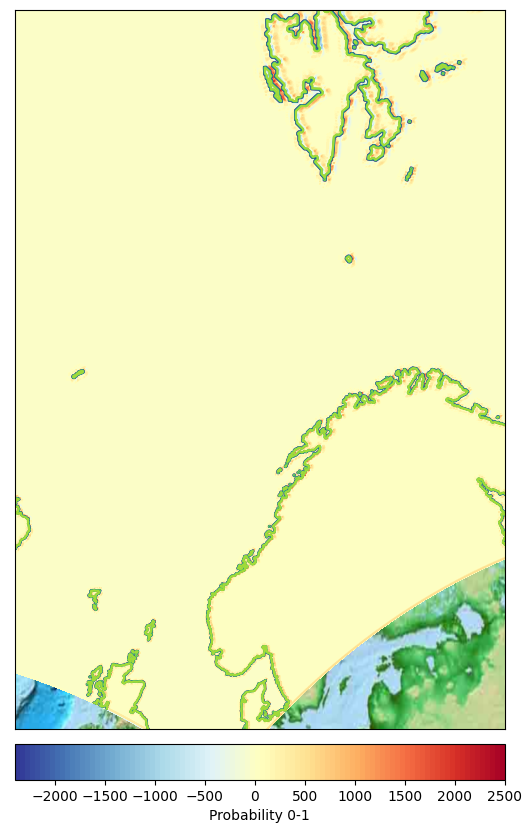

In [15]:
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------')
    train(dataloader, model, loss_fn, optimizer)
print('Done!')
pred = model(dataloader[0][0])
depth = ds['depth']
print(depth.mask)
print_on_map(pred,latlons,depth=depth)


In [13]:

depth = ds['depth']
values = []
'''
for i in range(depth.shape[0]):
    if i%10 == 0: print(i)
    for j in range(depth.shape[1]):
        d = depth[i,j]
        if d is np.ma.masked: continue
        #values.append(type(d.data))
        if d.data not in values: 
            values.append(d.data)
            #print([v.data for v in values])

        print(d.data)
        #values.append(d)
        #print(values)
        '''

0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
20.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
20.0
20.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
20.0
20.0
15.0
15.0
19.857143
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
20.0
20.0
20.0
20.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.